# Information Analysis and Visualisation (COMP1844)
## Vũ Trần Quang Minh - 001325733 - COS1104
### Task 1: Develop a Python program which generates the image of the map:

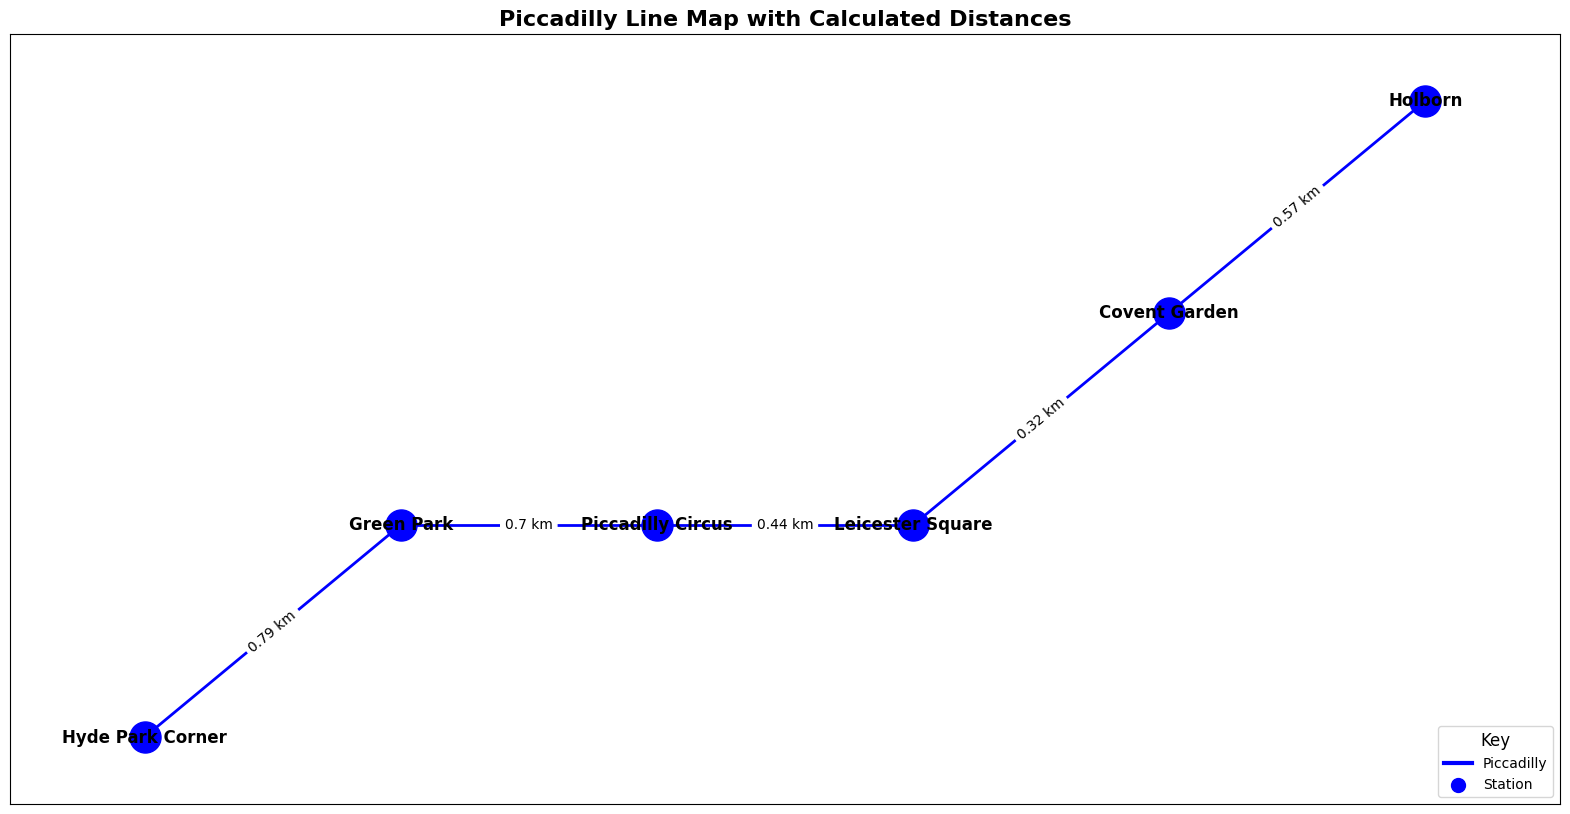

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file
file_path = 'London stations.csv'  # Replace with the actual file path
stations_data_csv = pd.read_csv(file_path)
stations_data_csv.columns = stations_data_csv.columns.str.strip()  # Remove extra spaces

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
# Define stations and their visualization coordinates
stations = {
    "Hyde Park Corner": (0, 0),
    "Green Park": (1, 1),
    "Piccadilly Circus": (2, 1),
    "Leicester Square": (3, 1),
    "Covent Garden": (4, 2),
    "Holborn": (5, 3)
}

# Define edges (station pairs) without distances
edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
]

# Calculate distances using haversine function
calculated_edges = []
for edge in edges:
    station1 = stations_data_csv[stations_data_csv['Station'] == edge[0]].iloc[0]
    station2 = stations_data_csv[stations_data_csv['Station'] == edge[1]].iloc[0]
    distance = haversine(
        station1['Latitude'], station1['Longitude'],
        station2['Latitude'], station2['Longitude']
    )
    calculated_edges.append((edge[0], edge[1], round(distance, 2)))

# ------------------- Graph Creation -------------------
# Create the graph
G = nx.Graph()

# Add nodes with positions
for station, coords in stations.items():
    G.add_node(station, pos=coords)

# Add edges with calculated distances
for edge in calculated_edges:
    G.add_edge(edge[0], edge[1], distance=edge[2])

# ------------------- Visualization Settings -------------------
# Get positions and edge labels
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'distance')

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))
ax = plt.gca()

# Draw nodes (stations)
nx.draw_networkx_nodes(
    G, pos, node_size=500, node_color='blue'
)

# Draw edges (connections)
nx.draw_networkx_edges(
    G, pos, edge_color='blue', width=2
)

# Draw station labels
nx.draw_networkx_labels(
    G, pos, font_size=12, font_weight='bold', font_color='black'
)

# Draw edge labels with distances
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={edge: f"{dist} km" for edge, dist in edge_labels.items()},
    font_size=10, font_color='black'
)

# ------------------- Add Legend and Final Adjustments -------------------
# Add legend for the line and nodes
plt.plot([], [], color='blue', linewidth=3, label='Piccadilly')  # Line for the Piccadilly line
plt.scatter([], [], color='blue', s=100, label='Station')  # Circle for the stations
plt.legend(
    loc='lower right', title='Key', frameon=True, fontsize=10, title_fontsize=12
)

# Add title and show plot
plt.title("Piccadilly Line Map with Calculated Distances", fontsize=16, fontweight='bold')
plt.show()
